In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"odndikcjfjd","key":"a43b0b892b4531e37a55aed204a5011e"}'}

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json 

In [6]:
!mkdir traffic_sign_dataset
%cd traffic_sign_dataset

/content/traffic_sign_dataset


In [7]:
!kaggle datasets list -s gtsrb-german-traffic-sign

ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meowmeowmeowmeowmeow/gtsrb-german-traffic-sign                     GTSRB - German Traffic Sign Recognition Benchmark  612MB  2018-11-25 18:12:34          79740        950  0.8235294        
valentynsichkar/traffic-signs-preprocessed                         Traffic Signs Preprocessed                           4GB  2019-08-31 18:22:11          10120        245  1.0              
eunjurho/german-traffic-sign-recognition-benchmark-cropped         german_traffic_sign_recognition_benchmark_cropped  206MB  2019-11-10 15:22:13            358          9  0.75             
ibrahimkaratas/gtsrb-german-traffic-sign-recogniti

In [8]:
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
%cd ..

 97% 593M/612M [00:04<00:00, 189MB/s]
100% 612M/612M [00:04<00:00, 147MB/s]
/content


In [9]:
!unzip traffic_sign_dataset/gtsrb-german-traffic-sign.zip -d traffic_sign_dataset
!rm traffic_sign_dataset/gtsrb-german-traffic-sign.zip
!rm -rf traffic_sign_dataset/Meta
!rm -rf traffic_sign_dataset/meta
!rm -rf traffic_sign_dataset/test
!rm -rf traffic_sign_dataset/train
!rm traffic_sign_dataset/Meta.csv

Streaming output truncated to the last 5000 lines.
  inflating: traffic_sign_dataset/train/5/00005_00053_00010.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00011.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00012.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00013.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00014.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00015.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00016.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00017.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00018.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00019.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00020.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00021.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00022.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00023.png  
  inflating: traffic_sign

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

Importing required libraries

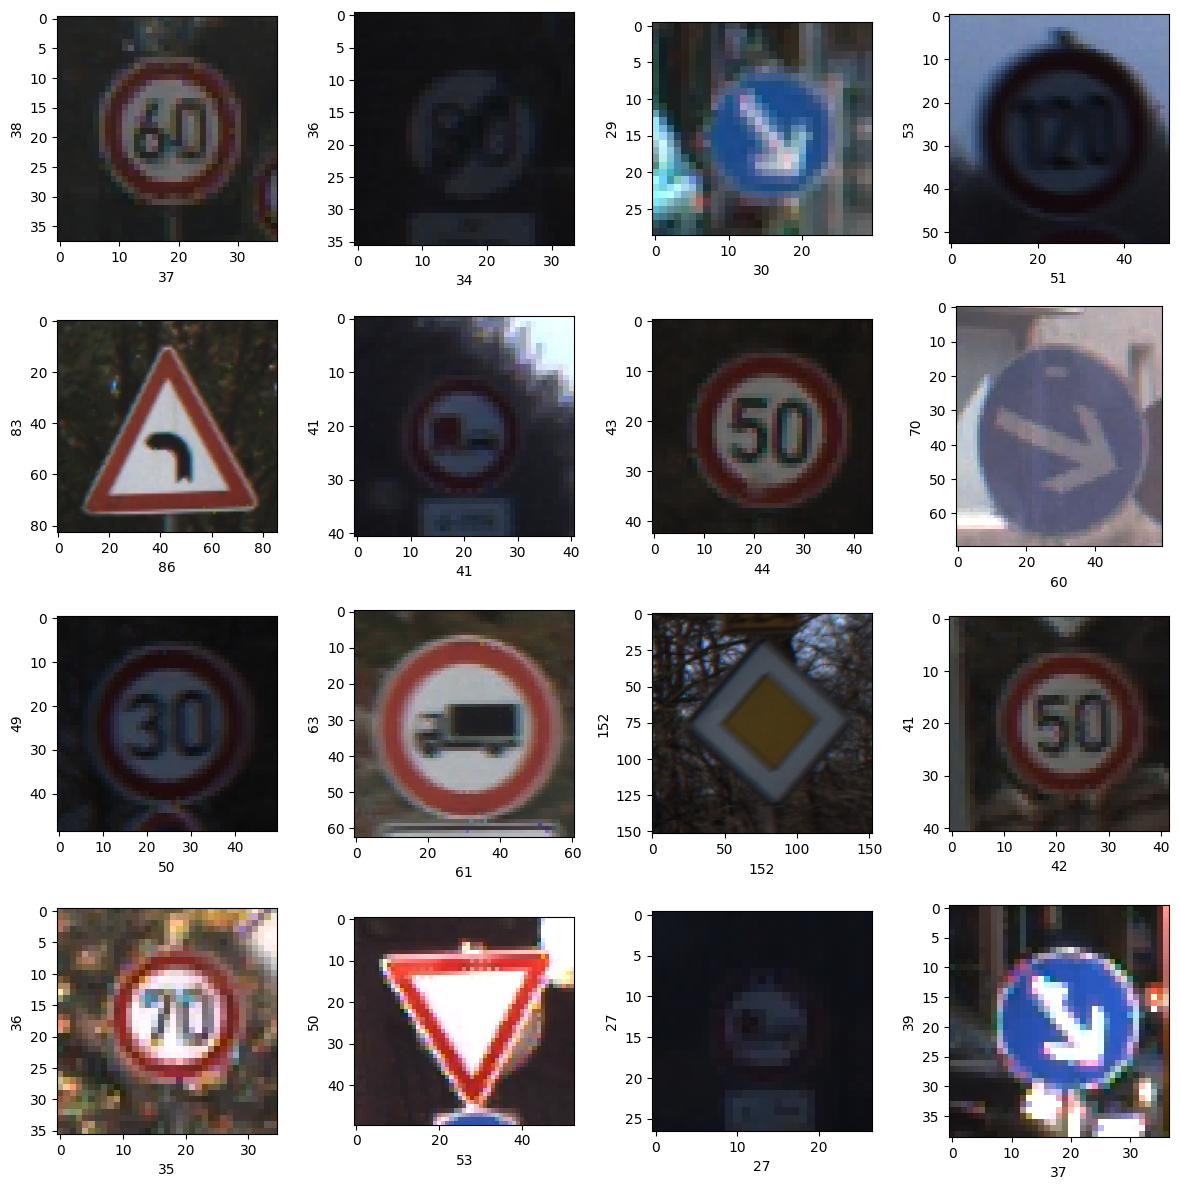

In [11]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = "traffic_sign_dataset/Test"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

In [12]:
dim1 = []
dim2 = []

for i in range(0,43):
    labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = imread(labels + '/' + x)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])

In [13]:
print("Dimension 1 Mean: ", np.mean(dim1), "Dimension 2 Mean: ", np.mean(dim2))

Dimension 1 Mean:  50.328929582493814 Dimension 2 Mean:  50.83587951745773


In [14]:
# Now we will reshape the images to (50,50)
images = []
label_id = []

for i in range(43):
    labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = Image.open(labels + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)
        label_id.append(i)

In [15]:
images = np.array(images)

images/255

array([[[[0.37647059, 0.37647059, 0.39215686],
         [0.37647059, 0.37254902, 0.38823529],
         [0.36862745, 0.36470588, 0.38039216],
         ...,
         [0.17647059, 0.16078431, 0.17254902],
         [0.18039216, 0.16862745, 0.17254902],
         [0.18039216, 0.17254902, 0.17647059]],

        [[0.40784314, 0.41176471, 0.43921569],
         [0.41960784, 0.41176471, 0.43921569],
         [0.41176471, 0.40784314, 0.43137255],
         ...,
         [0.25098039, 0.23137255, 0.25098039],
         [0.25098039, 0.23529412, 0.25098039],
         [0.24705882, 0.23529412, 0.24313725]],

        [[0.48235294, 0.48235294, 0.51764706],
         [0.48235294, 0.48235294, 0.50588235],
         [0.48627451, 0.4745098 , 0.49411765],
         ...,
         [0.3372549 , 0.32941176, 0.35294118],
         [0.33333333, 0.33333333, 0.35294118],
         [0.32941176, 0.3254902 , 0.34117647]],

        ...,

        [[0.68627451, 0.70588235, 0.75686275],
         [0.70588235, 0.71764706, 0.75294118]

In [16]:
label_id = np.array(label_id)
label_id.shape

(39209,)

In [17]:
images.shape

(39209, 50, 50, 3)

In [18]:
label_counts = pd.DataFrame(label_id).value_counts()
label_counts.head()

2     2250
1     2220
13    2160
12    2100
38    2070
dtype: int64

In [19]:
#Splitting the data
x_train, x_val, y_train, y_val = train_test_split(images, label_id , test_size = 0.2, random_state = 42)

In [20]:
#keras has a built-in function for one-hot encoding.
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

In [21]:
model = Sequential()


model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = x_train.shape[1:], activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size= (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation= 'relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation = 'softmax'))

In [22]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics= ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 64)        0

In [23]:
model.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_data = (x_val, y_val), verbose = 2)

Epoch 1/10
246/246 - 148s - loss: 5.1044 - accuracy: 0.0523 - val_loss: 3.6585 - val_accuracy: 0.0569 - 148s/epoch - 601ms/step
Epoch 2/10
246/246 - 146s - loss: 3.6229 - accuracy: 0.0574 - val_loss: 3.5880 - val_accuracy: 0.0571 - 146s/epoch - 594ms/step
Epoch 3/10
246/246 - 146s - loss: 3.5681 - accuracy: 0.0574 - val_loss: 3.5440 - val_accuracy: 0.0574 - 146s/epoch - 594ms/step
Epoch 4/10
246/246 - 154s - loss: 3.5351 - accuracy: 0.0574 - val_loss: 3.5172 - val_accuracy: 0.0574 - 154s/epoch - 625ms/step
Epoch 5/10
246/246 - 151s - loss: 3.5149 - accuracy: 0.0574 - val_loss: 3.5012 - val_accuracy: 0.0574 - 151s/epoch - 614ms/step
Epoch 6/10
246/246 - 150s - loss: 3.5037 - accuracy: 0.0574 - val_loss: 3.4920 - val_accuracy: 0.0574 - 150s/epoch - 611ms/step
Epoch 7/10
246/246 - 151s - loss: 3.4969 - accuracy: 0.0574 - val_loss: 3.4865 - val_accuracy: 0.0574 - 151s/epoch - 613ms/step
Epoch 8/10
246/246 - 157s - loss: 3.4932 - accuracy: 0.0574 - val_loss: 3.4834 - val_accuracy: 0.0574 - 

<Axes: >

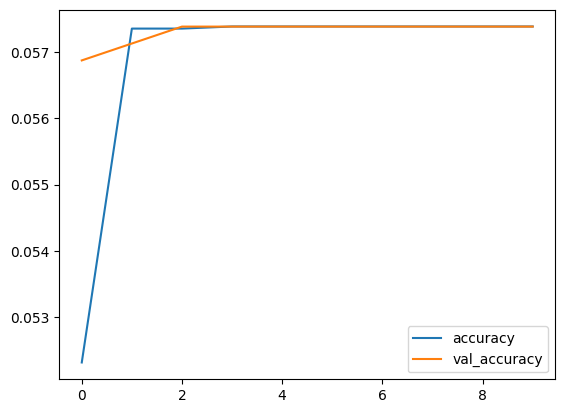

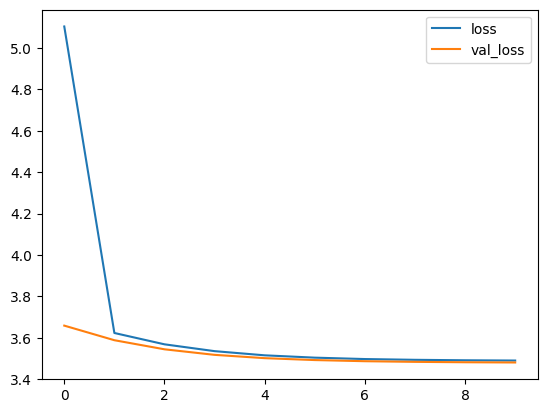

In [24]:
evaluation = pd.DataFrame(model.history.history)
evaluation[['accuracy', 'val_accuracy']].plot()
evaluation[['loss', 'val_loss']].plot()

In [25]:
test_path = 'traffic_sign_dataset/Test'
!rm traffic_sign_dataset/Test/GT-final_test.csv

In [26]:
from PIL import Image

def scaling(test_images, test_path):
    images = []

    image_path = test_images

    for x in image_path:
        img = Image.open(test_path + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)
    
    images = np.array(images)

    images = images / 255

    return images

In [27]:
test_images = scaling(sorted(os.listdir(test_path)),test_path)

In [28]:
test = pd.read_csv('traffic_sign_dataset/Test.csv')
y_test = test['ClassId'].values
y_test

array([16,  1, 38, ...,  6,  7, 10])

In [29]:
y_pred = (model.predict(test_images)).astype("int32")
y_pred


395/395 [==============================] - 13s 33ms/step


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [30]:
# Storing all lables
all_lables = ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)',
              'Speed limit (70km/h)','Speed limit (80km/h)','End of speed limit (80km/h)','Speed limit (100km/h)',
              'Speed limit (120km/h)','No passing','No passing for vechiles over 3.5 metric tons',
              'Right-of-way at the next intersection','Priority road','Yield','Stop','No vechiles',
              'Vechiles over 3.5 metric tons prohibited','No entry','General caution','Dangerous curve to the left',
              'Dangerous curve to the right','Double curve','Bumpy road','Slippery road','Road narrows on the right',
              'Road work','Traffic signals','Pedestrians','Children crossing','Bicycles crossing','Beware of ice/snow',
              'Wild animals crossing','End of all speed and passing limits','Turn right ahead','Turn left ahead',
              'Ahead only','Go straight or right','Go straight or left','Keep right','Keep left','Roundabout mandatory',
              'End of no passing','End of no passing by vechiles over 3.5 metric']


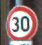

In [31]:
img = Image.open(test_path + '/00001.png')
img

In [32]:
# Original label
print("Orginal label : ", all_lables[y_test[1]])

Orginal label :  Speed limit (30km/h)


In [33]:
# Predicted label
print("Predicted label : ", all_lables[y_test[1]])

Predicted label :  Speed limit (30km/h)
